In [52]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from sklearn import preprocessing
import pandas as pd
import psycopg2
import faiss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
from psycopg2.extras import execute_values
import pickle
from tensorflow.keras.utils import plot_model
from faiss import write_index

# Load question embeddings

In [3]:
question_embeddings_model = Doc2Vec.load("python.doc")

# Create Dataset

In [4]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1",
                              port="54320", database="stack_overflow")

In [5]:
tag = 'python'
until_date = '2022-01-01'
# answers_samples = 12000
not_answers_samples = 2000000

In [6]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select count(1)
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        join posts_19 q_a ON q_a.parent_id = p.id
        where p.body_text is not null
        and p.post_type_id=1 
        and q_a.post_type_id=2 
        and p.creation_date < '{until_date}'
        and t.tag_name = '{tag}'""")
        total_answers = cursor.fetchall()
total_answers

[(1124030,)]

In [7]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select p.id, q_a.owner_user_id
                    from posts_19 p
                    join posts_19_tags pt on pt.post_id=p.id
                    join tags t on pt.tag_id=t.id
                    join posts_19 q_a ON q_a.parent_id = p.id
                    where p.body_text is not null
                    and p.post_type_id=1 
                    and q_a.post_type_id=2 
                    and q_a.owner_user_id is not NULL
                    and p.creation_date < '{until_date}'
                    and t.tag_name = '{tag}'
                    and p.id in %s""",
                    # limit {answers_samples}""",
                       (tuple(question_embeddings_model.dv.index_to_key),))
        answers_dataset = pd.DataFrame(cursor.fetchall(),
                                       columns=["question_id", "user_id"])
        answers_dataset["is_answer"] = 1

In [8]:
len(answers_dataset)

1114213

In [9]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select p.id, q_a.owner_user_id
                from posts_19 q_a, posts_19 p
                join posts_19_tags pt on pt.post_id=p.id
                join tags t on pt.tag_id=t.id
                where p.body_text is not null
                and random() <= 0.001
                and p.post_type_id=1
                and q_a.post_type_id=2
                and q_a.parent_id != p.id
                and q_a.owner_user_id is not NULL
                and p.creation_date < '{until_date}'
                and t.tag_name = '{tag}'
                and p.id in %s
                limit {not_answers_samples}""",
                       (tuple(question_embeddings_model.dv.index_to_key),))
        not_answers_dataset = pd.DataFrame(cursor.fetchall(),
                                           columns=["question_id", "user_id"])
        not_answers_dataset["is_answer"] = 0

In [10]:
dataset = pd.concat([answers_dataset, not_answers_dataset])

print(len(dataset))
dataset.head(5)

3114213


,question_id,user_id,is_answer
0,58458494,8451274,1
1,58458516,7432,1
2,58458664,4785185,1
3,51613638,6622587,1
4,58458843,2961785,1


In [11]:
test_size = .05

trainset, testset = train_test_split(dataset, test_size=test_size,
                                     random_state=42)
len(testset), len(trainset)

(155711, 2958502)

## Encode answers, questions and users

In [12]:
user_encoder = preprocessing.LabelEncoder()
user_encoder.fit(dataset["user_id"])
users_train = user_encoder.transform(trainset["user_id"])

user_embedding_dim = 10
total_users = len(user_encoder.classes_)
total_users

253571

In [13]:
question_encoder = preprocessing.LabelEncoder()
question_encoder.fit(dataset["question_id"])
questions_train = question_encoder.transform(trainset["question_id"])

total_questions = len(question_encoder.classes_)
total_questions

878620

In [14]:
answer_distances_train = 4*(1-trainset["is_answer"])

# Create distance model

In [15]:
embedding_matrix = np.zeros((len(question_encoder.classes_), question_embeddings_model.dv.vector_size))
for idx, q_id in enumerate(question_encoder.classes_):
    embedding_matrix[idx] = question_embeddings_model.dv[str(q_id)]

In [16]:
p_dropout = 0.3
transformation_1l_neurons = 25

user_id = tf.keras.layers.Input(shape=(), name="user_id")
normalized_user_embedding = tf.keras.layers.Embedding(total_users, user_embedding_dim,
                                           embeddings_constraint=tf.keras.constraints.UnitNorm(axis=1),
                                           trainable=True, name="normalized_user_embedding")(user_id)

question_id = tf.keras.layers.Input(shape=(), name="question_id")
question_embedding = tf.keras.layers.Embedding(total_questions, question_embeddings_model.dv.vector_size,
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                               trainable=False, name="question_embedding")(question_id)

question_transform_l01 = tf.keras.layers.Dense(transformation_1l_neurons, activation='sigmoid', name='question_transform_l01')(question_embedding)
question_transform_l02 = tf.keras.layers.Dropout(p_dropout, name='question_transform_l02')(question_transform_l01)
question_in_user_dim = tf.keras.layers.Dense(user_embedding_dim, activation='tanh', name='question_in_user_dim')(question_transform_l02)

normalized_question_in_user_dim = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=1), name="normalized_question_in_user_dim")(question_in_user_dim)
embeddings_difference = tf.keras.layers.Subtract(name="embeddings_difference")([normalized_user_embedding, normalized_question_in_user_dim])

embeddings_distance = tf.keras.layers.Lambda(lambda x: tf.norm(x, axis=1), name="embeddings_distance")(embeddings_difference)
distance_model = tf.keras.models.Model(inputs=[user_id, question_id], outputs=embeddings_distance, name="distance_model")
distance_model.summary()

Model: "distance_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question_id (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 question_embedding (Embedding)  (None, 50)          43931000    ['question_id[0][0]']            
                                                                                                  
 question_transform_l01 (Dense)  (None, 25)          1275        ['question_embedding[0][0]']     
                                                                                                  
 question_transform_l02 (Dropou  (None, 25)          0           ['question_transform_l01[0][0]'] 
 t)                                                                                  

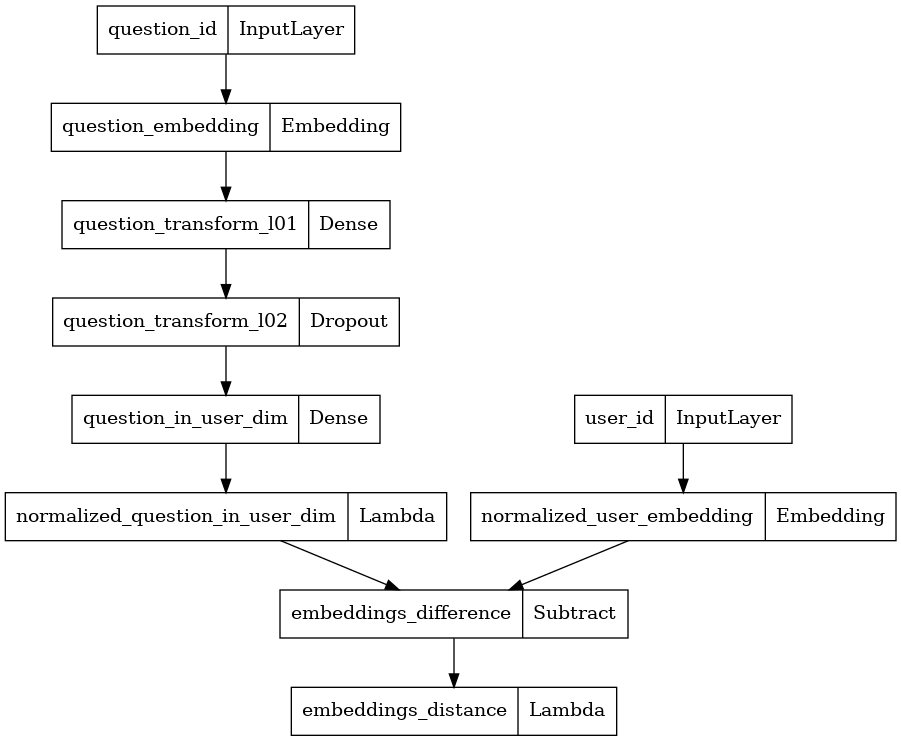

In [38]:
plot_model(distance_model) # Include dims

In [17]:
distance_model.compile(optimizer="rmsprop", loss="mse")

## Fit distance model

In [18]:
epochs_to_train = 30
validation_split = 0.05
batch_size = 128

history = distance_model.fit([users_train, questions_train], answer_distances_train,
                             validation_split = validation_split, epochs=epochs_to_train, batch_size = batch_size)

Epoch 1/30
21958/21958 [==============================] - 227s 10ms/step - loss: 3.5934 - val_loss: 3.3014
Epoch 2/30
21958/21958 [==============================] - 226s 10ms/step - loss: 3.2595 - val_loss: 3.2453
Epoch 3/30
21958/21958 [==============================] - 226s 10ms/step - loss: 3.2159 - val_loss: 3.2127
Epoch 4/30
21958/21958 [==============================] - 226s 10ms/step - loss: 3.1866 - val_loss: 3.1898
Epoch 5/30
21958/21958 [==============================] - 226s 10ms/step - loss: 3.1646 - val_loss: 3.1718
Epoch 6/30
21958/21958 [==============================] - 226s 10ms/step - loss: 3.1467 - val_loss: 3.1571
Epoch 7/30
21958/21958 [==============================] - 228s 10ms/step - loss: 3.1317 - val_loss: 3.1446
Epoch 8/30
21958/21958 [==============================] - 230s 10ms/step - loss: 3.1187 - val_loss: 3.1342
Epoch 9/30
21958/21958 [==============================] - 227s 10ms/step - loss: 3.1072 - val_loss: 3.1245
Epoch 10/30
21958/21958 [============

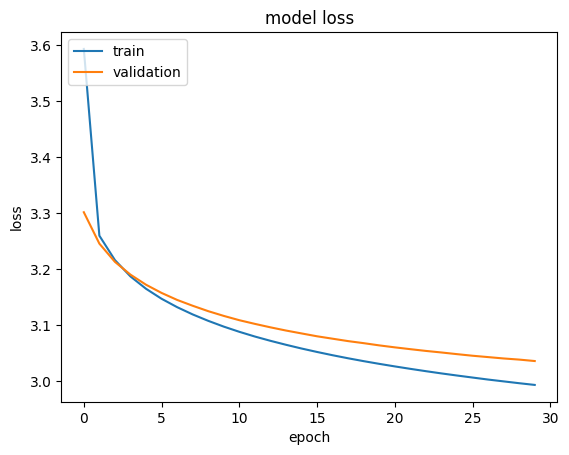

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
users_test = user_encoder.transform(testset["user_id"])
questions_test = question_encoder.transform(testset["question_id"])
answer_distances_test = 4*(1-testset["is_answer"])

In [21]:
distance_model.evaluate([users_test, questions_test], answer_distances_test)

4866/4866 [==============================] - 4s 737us/step - loss: 3.0311


3.0310935974121094

## Store users embeddings

In [53]:
with open('user_embeddings.pickle', 'wb') as f:
    pickle.dump((distance_model.get_layer('normalized_user_embedding').get_weights()[0], user_encoder), f)

# Create users index

In [22]:
(distance_model.get_layer('normalized_user_embedding').get_weights()[0]**2).sum(axis=1)

array([0.99999976, 0.9999998 , 0.9999999 , ..., 0.99999976, 0.99999976,
       0.9999999 ], dtype=float32)

In [23]:
index_type="IDMap,Flat"
index = faiss.index_factory(user_embedding_dim, index_type)


index.train(distance_model.get_layer('normalized_user_embedding').get_weights()[0])
index.add_with_ids(distance_model.get_layer('normalized_user_embedding').get_weights()[0], user_encoder.classes_)

## Store index

In [43]:
write_index(index, 'users_imp.index')

# Create question transformation

In [25]:
question_transformer_model = tf.keras.models.Model(inputs=distance_model.get_layer('question_embedding').output,
                                                   outputs=distance_model.get_layer('normalized_question_in_user_dim').output,
                                                   name="question_transformer_model")

question_transformer_model.summary()

Model: "question_transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 question_transform_l01 (Den  (None, 25)               1275      
 se)                                                             
                                                                 
 question_transform_l02 (Dro  (None, 25)               0         
 pout)                                                           
                                                                 
 question_in_user_dim (Dense  (None, 10)               260       
 )                                                               
                                                                 
 normalized_question_in_user  (None, 10)               0         
 _dim (Lambda)                          

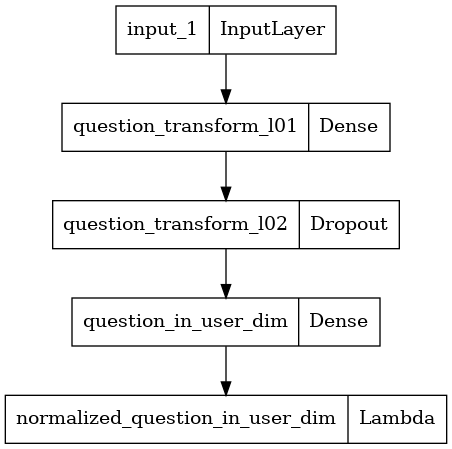

In [39]:
plot_model(question_transformer_model)

## Store questions transformation

In [40]:
question_transformer_model.save('question_transformer_model')

2023-06-30 00:54:11.441501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25]
	 [[{{node inputs}}]]
2023-06-30 00:54:11.547645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: question_transformer_model/assets


# Calculate recall

## Make dataset

In [26]:
MIN_ANSWERS = 9
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 3000""")
        posts = cursor.fetchall()

In [27]:
posts_vectors=[]
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(question_embeddings_model.infer_vector(simple_preprocess(post_text)))

In [28]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(1371, 50)

In [29]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

43/43 [==============================] - 0s 682us/step


(1371, 10)

## Calculate recall

In [30]:
def get_recall_dist(features_df):
    with connection:
        with connection.cursor() as cursor:
            execute_values(cursor, """
                                    with base_recs as (
                                        select q_id, u_id
                                        FROM (VALUES %s) AS base_data (q_id, u_id)
                                    ),
                                    answers_per_question as (
                                        select a.parent_id as q_id, count(*) as answers
                                        FROM posts_19 a
                                        WHERE a.parent_id in (select distinct q_id FROM base_recs)
                                        GROUP BY a.parent_id),
                                    retrieved_answers_per_question as (
                                        select a.parent_id as q_id, count(*) as answers
                                        FROM posts_19 a
                                        JOIN base_recs on q_id = a.parent_id
                                        WHERE a.owner_user_id = base_recs.u_id
                                        GROUP BY a.parent_id)
                                    
                                    select COALESCE(retrieved_answers_per_question.answers, 0) / answers_per_question.answers::float
                                    FROM answers_per_question 
                                    LEFT JOIN retrieved_answers_per_question
                                    ON answers_per_question.q_id = retrieved_answers_per_question.q_id""",
                                    features_df[["q_id", "u_id"]].values.tolist(), page_size=len(features_df))
            recalls = np.array(cursor.fetchall()).flatten()
    return recalls.mean(), recalls.std()

In [31]:
distances, similar_questions = index.search(questions_transformed[:3], 15)
features_df = pd.DataFrame(list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)
features_df = pd.concat([features_df, pd.DataFrame([(3061, 25450), (3061, 5532667), (22676, 14927325), (22676, 15760624), (22676, 394)], columns=["q_id", "u_id"])])

In [32]:
get_recall_dist(features_df)

(0.13203463203463203, 0.09429879182161023)

In [33]:
test_k = [50, 100, 500, 1000, 5000, 10000, 30000, 50000]

recall_dist = []
for k in test_k:
    distances, cand_users = index.search(questions_transformed[:50], k)
    features_df = pd.DataFrame(list(zip(posts_ids, cand_users)), columns=["q_id", "u_id"]).explode("u_id")
    features_df["u_id"] = features_df["u_id"].astype(int)
    recall_dist.append(get_recall_dist(features_df))
recall_dist = np.array(recall_dist)

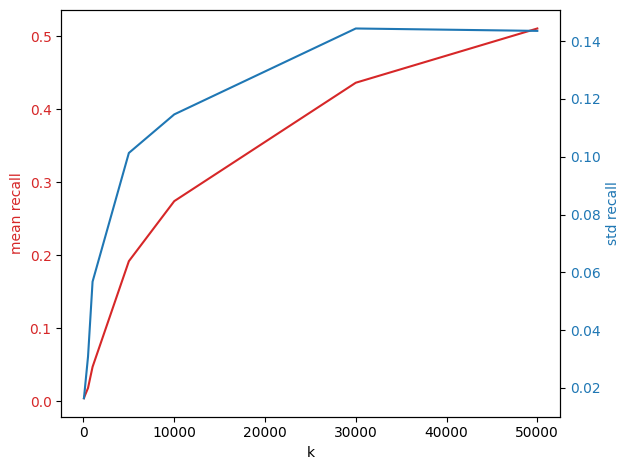

In [34]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('mean recall', color=color)
ax1.plot(test_k, recall_dist[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('std recall', color=color) 
ax2.plot(test_k, recall_dist[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [35]:
recall_dist

array([[0.00397727, 0.01639872],
       [0.00595996, 0.01798335],
       [0.01803403, 0.03082867],
       [0.04697505, 0.05675772],
       [0.19192314, 0.10131895],
       [0.27422979, 0.11466683],
       [0.43659955, 0.14441037],
       [0.51096245, 0.14357951]])